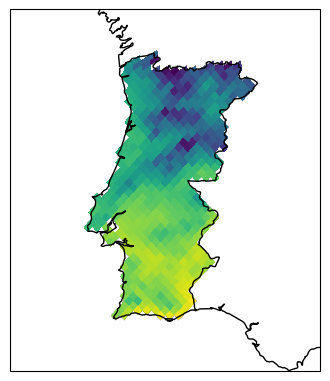

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import easygems.healpix as egh
import intake
import matplotlib.pyplot as plt
import numpy as np
import shapefile
import shapely
from cartopy.io import shapereader


def get_shapes(resolution="10m"):
    """Return a dictionary that maps ISO A3 country codes to shapely geometries."""
    shpfilename = shapereader.natural_earth(resolution, "cultural", "admin_0_countries")

    records = shapefile.Reader(shpfilename).records()
    shapes = shapefile.Reader(shpfilename).shapes()

    return {r["ISO_A3_EH"]: shapely.geometry.shape(s) for r, s in zip(records, shapes)}


# Load ICON online catalog
cat = intake.open_catalog("https://data.nextgems-h2020.eu/online.yaml")
ds = cat.ICON.ngc4008(zoom=9, chunks={}).to_dask().pipe(egh.attach_coords)

# Select regional polygon (e.g. Portugal) from HEALPix grid
shapes = get_shapes()
polygon = shapes["PRT"]

icell = np.where(
    shapely.contains_xy(polygon, ((ds.lon.values - 180) % 360) - 180, ds.lat.values)
)[0]

# Plot regional cutout
fig, ax = plt.subplots(figsize=(4, 5), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-11, -5, 36, 43])
ax.coastlines()
ax.add_feature(cf.BORDERS)
egh.healpix_show(ds["tas"].sel(cell=icell, time="2025").mean("time"))